# [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) [local-paper](http://localhost:8888/notebooks/Dropbox/Paper/1511.06434.pdf) [code-Newmu](https://github.com/Newmu/dcgan_code) [code-carpedm20](https://github.com/carpedm20/DCGAN-tensorflow) [code-nalsil](https://github.com/nalsil/dcgan-completion.tensorflow) [Improved DCGAN](https://arxiv.org/pdf/1606.03498.pdf) [local-paper](http://localhost:8888/notebooks/Dropbox/Paper/1606.03498.pdf)

<img src="img/DCGAN2.png"/>

<img src="img/DCGAN3.png"/>

<img src="img/DCGAN4.png"/>

<ul>
  <li>Batch normalization is a must in both networks.</li>
  <li>Fully hidden connected layers are not a good idea.</li>
  <li>Avoid pooling, simply stride your convolutions!</li>
  <li>Use LeakyReLU instead of ReLU.</li>
  <li>Use Adam optimizer ( lr = 0.0002, a = 0.9, b=0.5 ).</li>
</ul>

초짜 대학원생의 입장에서 이해하는 DCGAN 
[1](http://jaejunyoo.blogspot.com/2017/02/deep-convolutional-gan-dcgan-1.html)
[2](http://jaejunyoo.blogspot.com/2017/02/deep-convolutional-gan-dcgan-2.html)

Generative Adversarial Networks Explained with a Classic Spongebob Squarepants Episode [Arthur Juliani](https://medium.com/@awjuliani/generative-adversarial-networks-explained-with-a-classic-spongebob-squarepants-episode-54deab2fce39)

<img src="img/What can GAN do 1.png"/>

<img src="img/What can GAN do 2.png"/>

<img src="img/What can GAN do 3.png"/>

[A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf) [local-paper](http://localhost:8888/notebooks/Dropbox/Paper/1603-07285.pdf)

Generative Adversarial Networks [Hossein Azizpour](https://www.kth.se/social/files/59086d09f2765460c378ca73/GANs.pdf) [local-paper](http://localhost:8888/notebooks/Dropbox/Paper/GANs - Hossein Azizpour.pdf)


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Number of train samples: 55000, Shape of y: (55000, 10), Shape of X: (55000, 784)
0.0
1.0


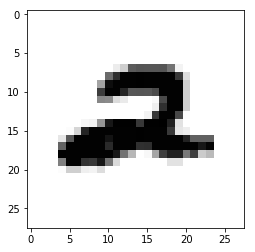

TypeError: __init__() got an unexpected keyword argument 'a'

In [1]:
# https://gist.github.com/awjuliani/8ebf356d03ffee139659807be7fa2611#file-dcgan-ipynb

import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy

z_size = 100 # Size of z vector used for generator.
batch_size = 128 # Size of image batch to apply at each iteration.
batch_size_sample = 36
iterations = 500000 # Total number of iterations to use.
sample_directory = './figs' # Directory to save sample images from generator in.
model_directory = './models' # Directory to save trained model to.

# Load data
try:
    mnist = input_data.read_data_sets("data/MNIST/", one_hot=True)
except:
    mnist = input_data.read_data_sets('../../Data/MNIST', one_hot=True)
    
n_samples = mnist.train.num_examples
X_dim = mnist.train.images.shape[1] # 28 * 28 = 784
y_dim = mnist.train.labels.shape[1] # 10
print("Number of train samples: {}, Shape of y: {}, Shape of X: {}"
      .format(mnist.train.num_examples, mnist.train.labels.shape, mnist.train.images.shape))
print(mnist.train.images.min())
print(mnist.train.images.max())
plt.imshow(np.reshape(-mnist.train.images[4242], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
plt.show()

# Helper Functions - This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
            f1 = 0.5 * (1 + leak)
            f2 = 0.5 * (1 - leak)
            return f1 * x + f2 * abs(x)
    
# Helper Functions - The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
# They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image
    return img

# Defining the Adversarial Networks - Generator Network
def generator(z):
    
    zP = slim.fully_connected(z,4*4*256,normalizer_fn=slim.batch_norm,
        activation_fn=None,scope='g_project',weights_initializer=initializer)
    zCon = tf.reshape(zP,[-1,4,4,256])
    
    # tf.nn.conv2d_transpose(value, filter, output_shape, strides, padding, name)
    gen1 = slim.convolution2d_transpose(
        zCon,num_outputs=64,kernel_size=[5,5],stride=[2,2],
        padding="SAME",normalizer_fn=slim.batch_norm,
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    
    gen2 = slim.convolution2d_transpose(
        gen1,num_outputs=32,kernel_size=[5,5],stride=[2,2],
        padding="SAME",normalizer_fn=slim.batch_norm,
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    
    g_out = slim.convolution2d_transpose(
        gen2,num_outputs=1,kernel_size=[5,5],stride=[2,2],
        padding="SAME",
        activation_fn=tf.nn.sigmoid,scope='g_conv3', weights_initializer=initializer)
    
    return g_out

# Defining the Adversarial Networks - Discriminator Network
def discriminator(bottom, reuse=False):
    
    dis1 = slim.convolution2d(bottom,16,[4,4],stride=[2,2],padding="SAME",
        biases_initializer=None,activation_fn=lrelu,
        reuse=reuse,scope='d_conv1',weights_initializer=initializer)
    
    dis2 = slim.convolution2d(dis1,32,[4,4],stride=[2,2],padding="SAME",
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,
        reuse=reuse,scope='d_conv2', weights_initializer=initializer)
    
    dis3 = slim.convolution2d(dis2,64,[4,4],stride=[2,2],padding="SAME",
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,
        reuse=reuse,scope='d_conv3',weights_initializer=initializer)
    
    d_out = slim.fully_connected(slim.flatten(dis3),1,activation_fn=tf.nn.sigmoid,
        reuse=reuse,scope='d_out', weights_initializer=initializer)
    
    return d_out

# Defining the Adversarial Networks - Connecting them together
tf.reset_default_graph()

# This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

# These two placeholders are used for input into the generator and discriminator, respectively.
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32) #Real images

Gz = generator(z_in) #Generates images from random z vectors
Dx = discriminator(real_in) #Produces probabilities for real images
Dg = discriminator(Gz,reuse=True) #Produces probabilities for generator images

# These functions together define the optimization objective of the GAN.
d_loss = - tf.reduce_mean(tf.log(Dx)) - tf.reduce_mean(tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss =                              - tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

# The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

saver = tf.train.Saver()
with tf.Session() as sess:  
    tf.global_variables_initializer().run()
    
    for i in range(iterations):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.pad.html
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs})
        if i % 10 == 0:
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
            newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            save_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
        if i % 1000 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print("Saved Model")
            
saver = tf.train.Saver()
with tf.Session() as sess:  
    tf.global_variables_initializer().run()
    
    #Reload the model.
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(model_directory)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    zs = np.random.uniform(-1.0,1.0,size=[batch_size_sample,z_size]).astype(np.float32) #Generate a random z batch
    newZ = sess.run(Gz,feed_dict={z_in:z2}) # Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    save_images(np.reshape(newZ[0:batch_size_sample],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')